
Generating IID samples from the 2D bimodal posterior...



/home/fabian/anaconda3/envs/pymc_immo_env/lib/python3.12/site-packages/pytensor/tensor/rewriting/math.py:2397: RuntimeWarning: invalid value encountered in scalar subtract
  v = reduce(np.add, num, zero) - reduce(np.add, denum, zero)
Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
>Metropolis: [w]
>Metropolis: [mixed_normal]


Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


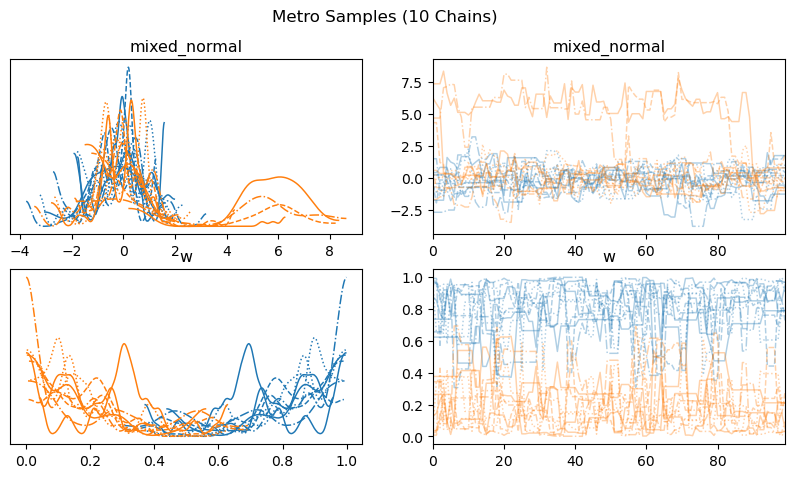

dim der samples
(10, 100, 2)
dim der iid samples
(1000, 2)


Multiprocess sampling (10 chains in 4 jobs)
NUTS: [w, mixed_normal]


Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 6 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


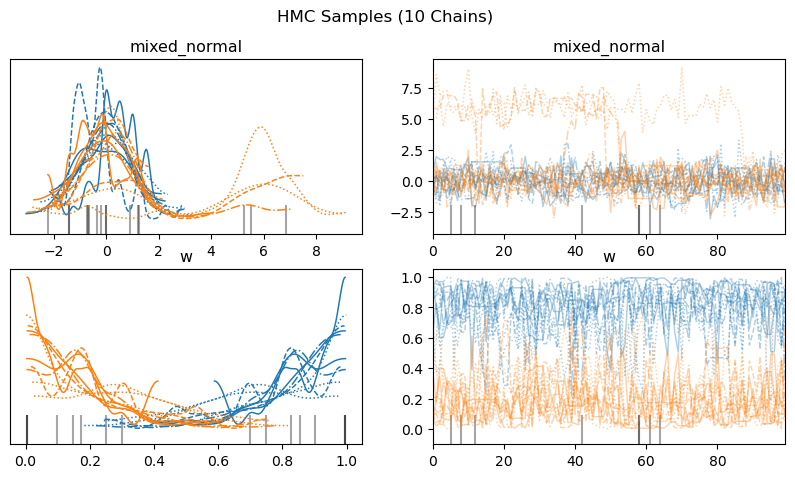

dim der samples
(10, 100, 2)
dim der iid samples
(1000, 2)


Population sampling (10 chains)
DEMetropolis: [w, mixed_normal]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Output()

Output()

Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


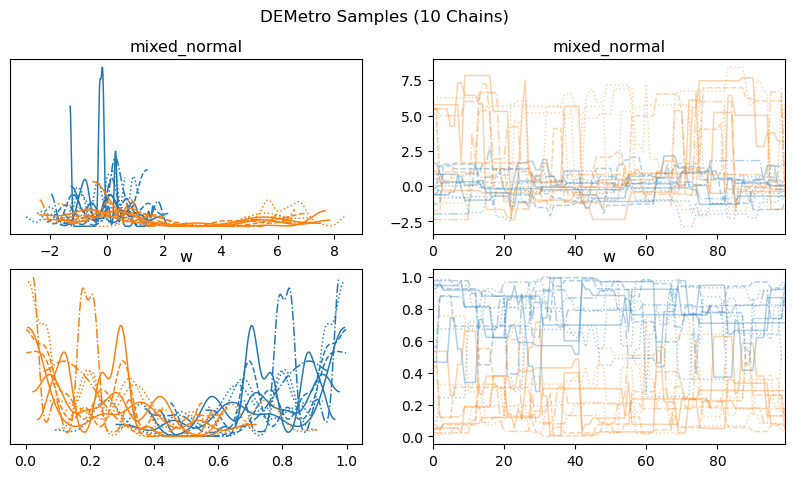

dim der samples
(10, 100, 2)
dim der iid samples
(1000, 2)


In [6]:
import numpy as np
import pymc as pm
import arviz as az
import scipy.stats as sp
import matplotlib.pyplot as plt


class WassersteinExample:
    
    def __init__(self, weights=[1,1]):
        self.model = self._bimodal_posterior_2d(weights)
    
    def _bimodal_posterior_2d(self, weights=[1,1]):        
        with pm.Model() as model:
            
            # Mixture weights
            w = pm.Dirichlet("w", a=np.array(weights))

            means = np.array([[0, 0], [0, 6]]) 

            # Define covariance matrices for each component
            covs = np.array([
                [[1, 0.5], [0.5, 1]],  # Covariance of component 1
                [[1, -0.3], [-0.3, 1]]  # Covariance of component 2
            ])
            
            # Multivariate normal components
            components = [pm.MvNormal.dist(mu=means[i], cov=covs[i]) for i in range(2)]
            
            # Mixture model
            mixed_normal = pm.Mixture("mixed_normal", w=w, comp_dists=components)

        return model

    def generate_iid_samples_2d(self, num_samples=2000, weights=[1,1]):
        """
        Generate IID samples from the 2D bimodal posterior.
        """
        print("\nGenerating IID samples from the 2D bimodal posterior...\n")

        # Normalize weights
        weights = np.array(weights) / np.sum(weights)

        # Define 2D means (centers of the two Gaussian modes)
        means = np.array([[0, 0], [0, 6]])

        # Define 2D covariance matrices
        covs = np.array([
            [[1, 0.5], [0.5, 1]],  # Component 1
            [[1, -0.3], [-0.3, 1]]  # Component 2
        ])

        # Step 1: Choose which component each sample comes from
        mode_indices = np.random.choice(len(means), size=num_samples, p=weights)

        # Step 2: Generate samples from the corresponding 2D Gaussian
        iid_samples = np.array([
            np.random.multivariate_normal(mean=means[idx], cov=covs[idx]) for idx in mode_indices
        ])
        

        return iid_samples
    


    def run_sampling(self, 
                     sampler_name, 
                     num_samples=2000, 
                     tune=1000, 
                     num_chains=2, 
                     initvals=None):

        with self.model:

            # Define which sampler to use
            if sampler_name == "Metro":
                sampler = pm.Metropolis()
            elif sampler_name == "HMC":
                sampler = pm.NUTS()
            elif sampler_name == "DEMetro":
                sampler = pm.DEMetropolis()
            else:
                raise ValueError(f"Unknown sampler: {sampler_name}")


            trace = pm.sample(num_samples, tune=tune, step=sampler, initvals= initvals,chains=num_chains, return_inferencedata=True, progressbar=True)
        
            az.plot_trace(trace, figsize=(10, 5)) #var_names=["mixed_normal"]
            plt.suptitle(f"{sampler_name} Samples ({num_chains} Chains)")
            plt.show()
        
        return trace
    


    def compute_wasserstein_distances(self, trace, iid_samples):
        
        mcmc_samples = trace.posterior["mixed_normal"].values.reshape(-1, 2)
        print("dim der samples")
        print(mcmc_samples.shape)
        ws_distance = sp.wasserstein_distance_nd(mcmc_samples, iid_samples)

        return ws_distance
    



# Define means for 2D components
means = np.array([[0, 0], [0, 6]])  # Two centers in 2D space

weights = [4, 1]

num_samples = 1000
#init_values = True

num_chains = 10

samples_per_chain = num_samples // num_chains

initvals = [
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 1 starts near Mode 2
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 2 starts near Mode 2
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]}, # Chain 3 starts near Mode 2
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]}, # Chain 4 starts near Mode 2
    {"w": np.array([0.9, 0.1]), "mixed_normal": means[0]},  # Chain 5 starts near Mode 2
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 6 starts near Mode 2
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]}, # Chain 7 starts near Mode 2
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]}, # Chain 8 starts near Mode 2
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 9 starts near Mode 2
    {"w": np.array([0.1, 0.9]), "mixed_normal": means[1]},  # Chain 10 starts near Mode 2
]

# Instantiate framework
framework = WassersteinExample(weights)

# Generate IID samples
iid_samples = framework.generate_iid_samples_2d(num_samples=num_samples, weights=weights)

ws_results = {}

traces = {}

r_hat_values = {}

for sampler_name in ["Metro","HMC","DEMetro"]:
    trace = framework.run_sampling(
        sampler_name,
        num_samples= samples_per_chain,
        num_chains= num_chains,
        initvals= initvals,
        )
    print("dim der samples")
    print(trace.posterior["mixed_normal"].values.shape)

    print("dim der iid samples")
    print(iid_samples.shape)
    #ws_distance = framework.compute_wasserstein_distances(trace, iid_samples)
    #ws_results[sampler_name] = ws_distance
 

    traces[sampler_name] = trace
    #print(f"{sampler_name}: Wasserstein Distance = {ws_distance:.4f}")




# Sort results
#ranked_ws = sorted(ws_results.items(), key=lambda x: x[1])



# Print ranked results
#print("\n### Ranked Sampler Performance ###")
#for rank, (sampler_name, ws_distance) in enumerate(ranked_ws, 1):
#    print(f"{rank}. {sampler_name}: {ws_distance:.4f}")



(array([ 4.,  3.,  0.,  0.,  0.,  2.,  0.,  2.,  5.,  3.,  2.,  5.,  9.,
         0.,  3.,  5.,  0., 11., 17., 17.,  3.,  3.,  5., 11.,  5., 18.,
        11., 29., 10., 23., 14., 34., 12., 17., 13., 18., 24., 39., 33.,
        24., 18., 27., 41., 13., 22., 23., 14., 24., 18., 26., 19., 12.,
        45.,  7., 12.,  6.,  8., 24.,  4., 13., 20., 13., 18., 10., 21.,
         4., 15.,  5.,  2.,  6.,  7.,  6., 10., 11., 14.,  2.,  2.,  6.,
         2.,  4.,  0.,  4.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([ 5.64574192,  5.700114  ,  5.75448609,  5.80885817,  5.86323025,
         5.91760234,  5.97197442,  6.02634651,  6.08071859,  6.13509068,
         6.18946276,  6.24383485,  6.29820693,  6.35257902,  6.4069511 ,
         6.46132319,  6.51569527,  6.57006736,  6.62443944,  6.67881153,
         6.73318361,  6.78755569,  6.84192778,  6.89629986,  6.95067195,
         7.00504403,  7.05941612,  7.1137882 ,  7.16816029,  7.222532

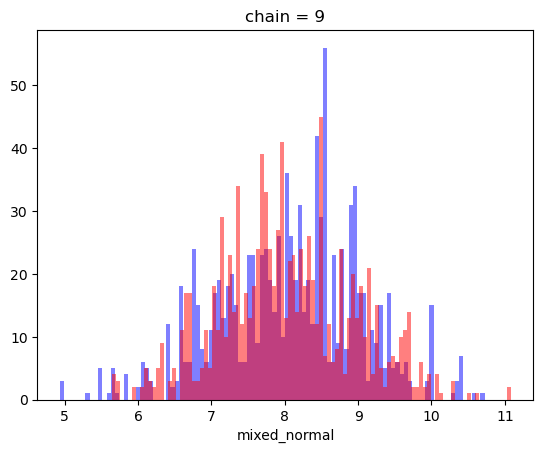

In [57]:
traces['DEMetro'].sel(chain=0).stack(sample=("draw")).posterior["mixed_normal"].plot.hist(bins=100, alpha=0.5, label="Metro", color="blue")
traces['DEMetro'].sel(chain=9).stack(sample=("draw")).posterior["mixed_normal"].plot.hist(bins=100, alpha=0.5, label="Metro", color="red")


In [ ]:

fig, ax = plt.subplots(2, 3, figsize=(15, 5))

for i, (sampler_name, trace) in enumerate(traces.items()):
    ax[0][i].hist(trace.posterior["mixed_normal"].values.flatten(), bins=50, alpha=0.5, label=sampler_name)
    ax[0][i].hist(iid_samples, bins=50, alpha=0.5, label="IID Samples")
    ax[0][i].set_title(sampler_name)
    ax[0][i].legend()

    
